# Gather insights of amazon reviews

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import re

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer

%matplotlib notebook

In [2]:
#nltk.download('stopwords')

In [3]:
# Loading the data 
path = 'data/All_reviews.csv'
df = pd.read_csv(path, dtype={"kindle":object})
df.drop(df.columns[0],axis=1, inplace=True)

# Defining colors:
kindle_colors= ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#fcfc05']

## Exploration of data

In [4]:
df.head(5)

,id,ASIN,stars,username,title,text,date,offer type,color,verified purchase,comments,kindle unlimited,digital storage,connectivity,kindle
0,R61N3CY1FPX2W,B004HZYA6E,5,Tina,Kindle Keyboard 3G—best Kindle ever!,This older Kindle Keyboard 3G is so much bette...,2018-07-26,Without Special Offers $159,Graphite,Verified Purchase,0,Na,Na,Na,3
1,R2MTWINM4NF9VF,B004HZYA6E,1,Justin,Won't register,Wish I could give it a good rating. Device wou...,2017-02-19,Without Special Offers $159,Graphite,Verified Purchase,0,Na,Na,Na,3
2,R3U661U4J3S6SI,B004HZYA6E,4,Shabang,"Used, cheap, free 3G kindle that plays audio f...",I owned one when they first came out and bough...,2016-12-01,Without Special Offers $159,Graphite,Verified Purchase,0,Na,Na,Na,3
3,R4HJIQ9JJS51V,B004HZYA6E,5,eastcoast,Still love it in July of 2014,"I still love this---- even in July, 2014! I h...",2014-07-05,Without Special Offers $159,Graphite,Verified Purchase,0,Na,Na,Na,3
4,R1XZB69R0HWBD4,B004HZYA6E,5,Patricia,Best E-Reader Ever Made,This is BY FAR the best e-reader ever made. It...,2017-07-08,Without Special Offers $159,Graphite,Verified Purchase,0,Na,Na,Na,3


In [5]:
df.describe()

,stars,comments
count,169090.000000,169090.000000
mean,4.212928,0.232598
std,1.198218,1.186548
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,51.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169090 entries, 0 to 169089
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 169090 non-null  object
 1   ASIN               169090 non-null  object
 2   stars              169090 non-null  int64 
 3   username           169090 non-null  object
 4   title              169089 non-null  object
 5   text               169090 non-null  object
 6   date               169089 non-null  object
 7   offer type         169090 non-null  object
 8   color              156772 non-null  object
 9   verified purchase  169090 non-null  object
 10  comments           169090 non-null  int64 
 11  kindle unlimited   169090 non-null  object
 12  digital storage    169090 non-null  object
 13  connectivity       169090 non-null  object
 14  kindle             169090 non-null  object
dtypes: int64(2), object(13)
memory usage: 19.4+ MB


In [7]:
df.corr()

,stars,comments
stars,1.000000,-0.272035
comments,-0.272035,1.000000


In [8]:
pd.plotting.scatter_matrix(df);

<IPython.core.display.Javascript object>

### Draw histogram of all data

In [9]:
#aggregate data
a = df.groupby(["kindle","id","date"], sort=False).count()
#extract one column
data = pd.DataFrame(a["ASIN"])

In [10]:
#Iterate through the kindles and apply the same operations
# extract the data for each kindle to be able to colorcode them
k3 = data.xs(key="3", level="kindle")
k4 = data.xs(key="4", level="kindle")
k5 = data.xs(key="5", level="kindle")
pw5 = data.xs(key="paperwhite 5", level="kindle")
pw6 = data.xs(key="paperwhite 6", level="kindle")
pw7 = data.xs(key="paperwhite 7", level="kindle")
k7 = data.xs(key="7", level="kindle")
v7 = data.xs(key="voyage 7", level="kindle")
k8 = data.xs(key="8", level="kindle")
o9 = data.xs(key="oasis 9", level="kindle")
pw10 = data.xs(key="paperwhite 10", level="kindle")
i=0
kindles = [k3, k4,k5, pw5, pw6, k7, v7, pw7, k8, o9, pw10]


for product in kindles: 
    #Convert the data into the correct format for matplotlib
    product.reset_index(inplace=True)
    product.drop(product.columns[0],axis=1, inplace=True)
    product.set_index('date', inplace=True)
    product.index = pd.to_datetime(product.index).copy()
    product = mpl.dates.date2num(product.index.to_pydatetime()).copy()
    kindles[i] = product
    i+=1

/Users/jj/Documents/udacity/mining_kindle_reviews/venv/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
legend = ["Kindle 3", "Kindle 4", "Kindle 5", "Paperwhite 5",
               "Paperwhite 6", "Kindle 7", "Voyage 7", "Paperwhite 7", "Kindle 8", "Oasis 9", "Paperwhite 10"]
fig = plt.figure(figsize=(10,5))
s = fig.add_subplot(111)
#Data needs to be an array to work
s.hist(kindles,bins=120,stacked=True, color=kindle_colors, alpha=1)
s.xaxis.set_major_locator(mdates.YearLocator())
s.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
s.legend(legend);

<IPython.core.display.Javascript object>

## Analyse how the price affects the ratings

In [12]:
def bi_dict_analysis(df, dictio_filename):
    """
    Dictionary analysis that checks whether words defined in a dictionary are mentioned in a string.
    Expects a dataframe through which rows it will iterate.
    INPUT:
    df - a dataframe with the columns "kindle", "reviews", "title"
    dictio_filename - the file name of an excel file with one column for each topic to be analyzed
    
    OUTPUT:
    -dictio_df a dataframe with one column appended for every topic in the dictionary. The rows are marked if the topic is mentioned.
    -column_names column that were appended
    
    """

    df['kindle'] = df['kindle'].astype(str)
    df.reset_index(inplace=True)
    df.drop(df.columns[0],axis=1,inplace=True)
    
    #Combine title and text 
    df["reviews"] = df["title"].map(str) +" "+ df["text"]

    #Change the reviews type to string
    df['reviews'] = df['reviews'].astype(str)

    #Lowercase all reviews
    df.reviews = df.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))
    #Remove punctuation
    df.reviews = df.reviews.str.replace('[^\w\s]','')

    #Remove stop words
    stop = stopwords.words('english')
    stop.remove("not")
    stop.remove("with")
    df.reviews = df.reviews.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Import the dicionary for the analysis:
    dictio = pd.read_excel('dicts/'+dictio_filename)
    dictio = dictio.applymap(str)
      
    #Creates empty columns for the dictionaries
    column_names = []
    column_names = list(dictio.columns.values)
    df.reviews.dropna()
    #Saves all reviews in the sentences list
    sentences = df.reviews
    df= df.reindex(columns=[*df.columns.tolist(), *column_names], fill_value=np.NaN)
    
    #Analysis starts
    i=0
    #Iterates through the reviews
    total_length = len(sentences)
    #Since the analysis can take very long, some status statements are printed
    print("Process started:")
    s = 1
    #Iteration through every review
    for sentence in sentences:
        #Splits a review text into single words
        words = sentence.split()
        previous_word = ""
        #Iterates through the topics, each is one column in a table
        for column in dictio:
            #Saves the topic words in the pattern list
            pattern = list(dictio[column])
            #Remove empty values
            clean_pattern = [x for x in pattern if str(x) != 'nan']
            match_score = 0
            #Iterates through each entry of the topic list
            for search_words in clean_pattern:
                #Iterates through each word of the review
                for word in words:
                    #When two consecutive words are searched for the first if statement gets activated
                    if len(search_words.split())>1:

                        pattern2 = r"( "+re.escape(search_words.split()[0])+r"([a-z]+|) "+re.escape(search_words.split()[1])+r"([a-z]+|))"
                        #The spaces are important so bedtime doesnt match time
                        if re.search(pattern2, " "+previous_word+" "+word, re.IGNORECASE):
                            #If the word within the review matches the one in the dictionary the score is increased
                            match_score +=1

                    if len(search_words.split())==1:
                        pattern1 = r" "+re.escape(search_words)+r"([a-z]+|)"
                        if re.search(pattern1, " "+word, re.IGNORECASE):
                            match_score +=1

                    #Saves the word for the next iteration to be used as the previous word
                    #This enables to scan for two consecutive words
                    previous_word = word

            result=0 
            #If one word in the review matched one word of the dictionary, it is marked
            if match_score > 0:
                result = 1
            df.at[i, column] = int(result)
        i+=1
        #Prints current status
        factor = round(s/total_length,4)
        if factor%0.05 == 0:
            print("Status: "+str(factor*100)+"%")
        s+=1

    dictio_df = df.copy()
    print("Analysis successfull")
    return (dictio_df, column_names)

In [13]:
(df, column_names) = bi_dict_analysis(df, "price_dict.xlsx")

Process started:
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 0.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 5.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 10.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 20.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%
Status: 40.0%

In [19]:
#Changing Kindle names for alphabetical sorting
def rename(string):
    if string == "oasis 9":
        string = "9 oasis"
    if string == "paperwhite 10":
        string = "99 paperwhite ten"
    if string == "voyage 7":
        string = "7 voyage"
    if string == "paperwhite 5":
        string = "5 paperwhite"
    if string == "paperwhite 6":
        string = "6 paperwhite"
    if string == "paperwhite 7":
        string = "7 paperwhite"
    return string
wdf = df.copy()
wdf["total"]=1
wdf.kindle = wdf.kindle.apply(rename)
gdf = wdf.groupby("kindle").sum()

In [20]:
#Percentage of review that talk about a topic

gdf.drop(gdf.columns[0:1], axis=1, inplace=True)
gdf["price perc"] = 100*(gdf["price"])/(gdf["total"])
gdf["exp perc"] = 100*(gdf["expensive"])/(gdf["total"])
gdf["cheap perc"] = 100*(gdf["cheap"])/(gdf["total"])

In [21]:
kindle_barplot = kindle_latex = {"3":"Kindle 3","4":"Kindle 4","5":"Kindle 5", "5 paperwhite":"Paperwhite 5", "6 paperwhite":"Paperwhite 6","7": "Kindle 7", "7 paperwhite":"Paperwhite 7", "7 voyage":"Voyage","8":"Kindle 8","9 oasis":"Oasis","99 paperwhite ten":"Paperwhite 10"}

In [22]:
#Reindex with predefined dictionary
gdf.rename(index=kindle_barplot,inplace=True)
#Drop unneccessary columns
gdf.drop(gdf.columns[0:4], axis =1, inplace=True)

In [23]:
bdf = gdf.copy()

<IPython.core.display.Javascript object>


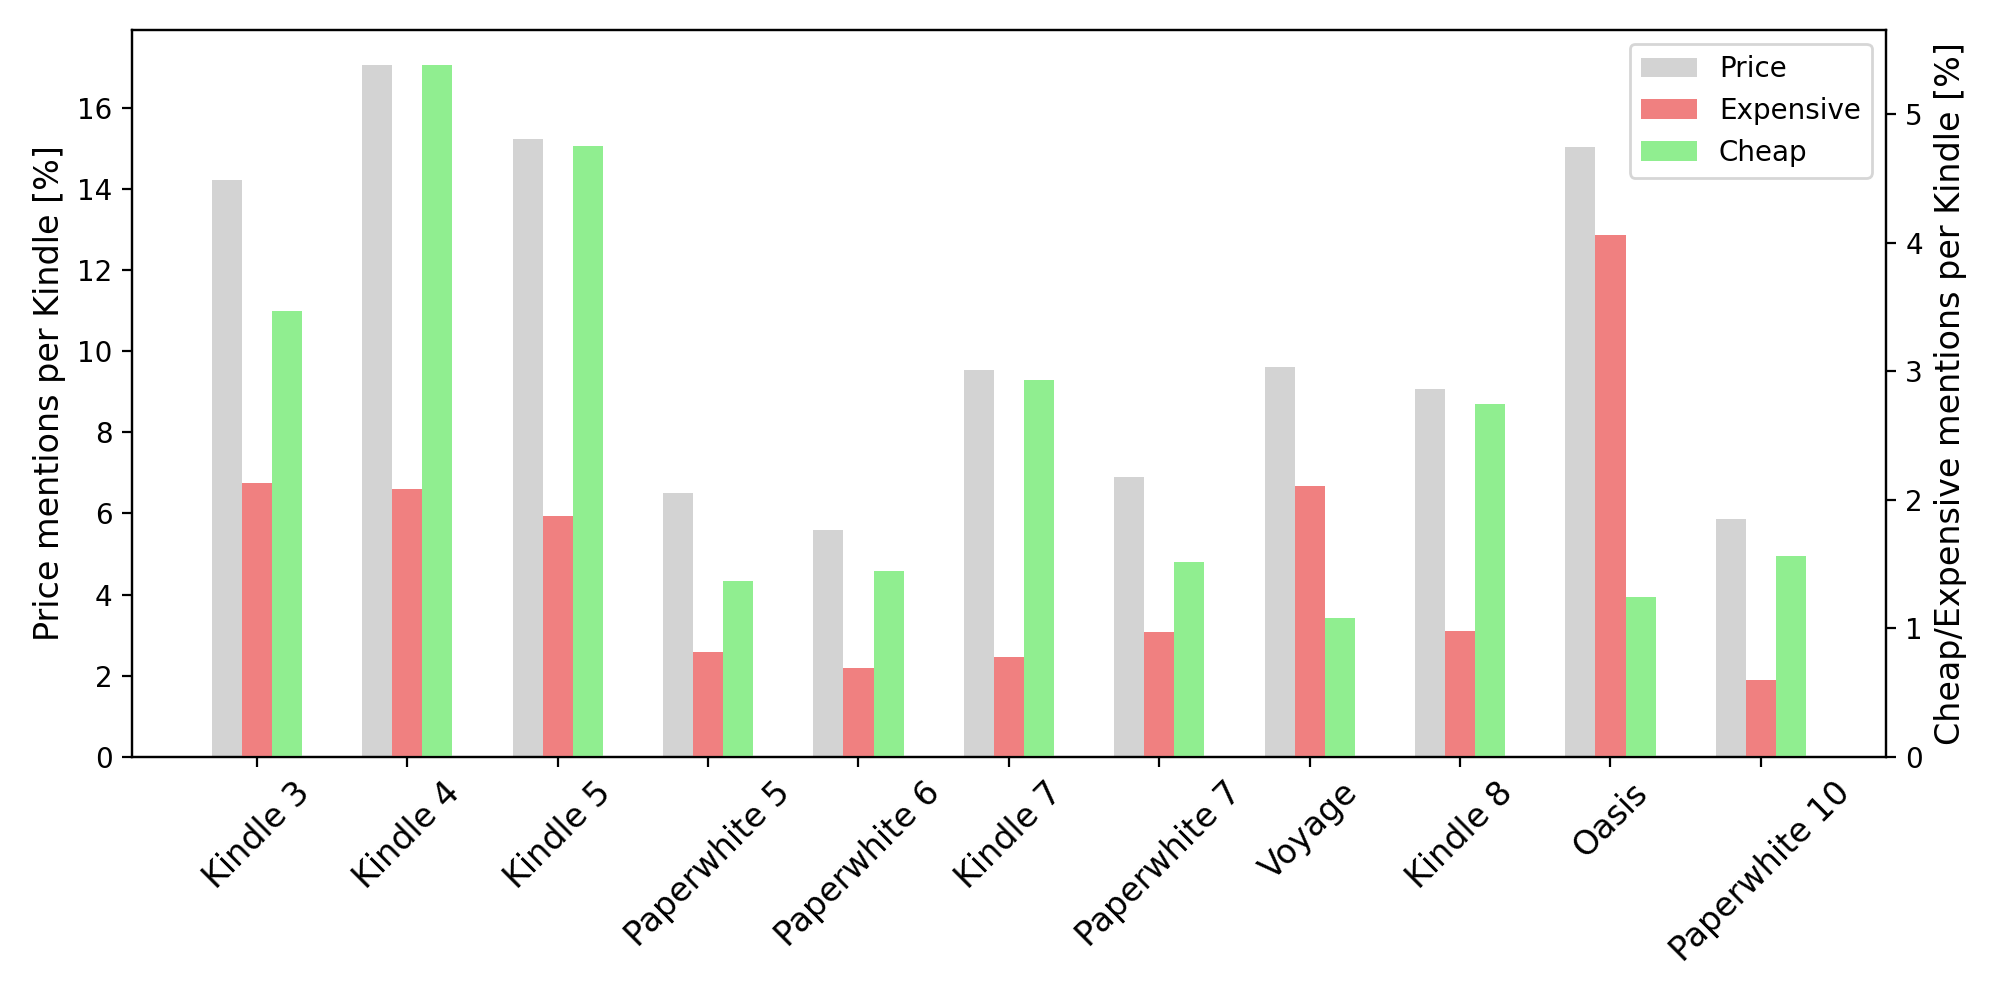

In [24]:
#Draws the graph that compares how often the topics are mentioned for each Kindle
price = list(bdf["price perc"])
exp = list(bdf["exp perc"])
cheap = list(bdf["cheap perc"])

ind = np.arange(len(price))
width = 0.2

fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
rects1 = ax.bar(ind-(width), price, width, label="Price", color="lightgrey")
rects11 = ax.bar(ind, exp, width, label="Expensive", color="lightcoral")
rects111= ax.bar(ind+(width), cheap, width, label="Cheap",color="lightgreen")
rects2 = ax2.bar(ind, exp, width, label="Expensive", color="lightcoral")
rects3 = ax2.bar(ind+(width), cheap, width, label="Cheap",color="lightgreen")

ax.set_ylabel("Price mentions per Kindle [%]", size=12)
ax2.set_ylabel("Cheap/Expensive mentions per Kindle [%]", size=12)
ax.set_xticks(ind)
ax.set_xticklabels(bdf.index.values,rotation=45, size = 12)

ax.legend()
fig.tight_layout()
plt.show()